In [39]:
import pickle
import sklearn as mp
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import datetime as dt
import numpy as np
import csv
import os
# Allows plots to appear directly in the notebook.
%matplotlib inline

In [40]:

%%capture
# capture magic method allows to hide the output cell
# define tables here so that they would be visible during the model prediciton
CurrentWeather = """
    CREATE TABLE IF NOT EXISTS CurrentWeather (
        time_update DATETIME NOT NULL,
        current_weather_id INT AUTO_INCREMENT PRIMARY KEY,
        feels_like DECIMAL(5, 2) NOT NULL,
        temperature_min DECIMAL(5, 2) NOT NULL,
        temperature_max DECIMAL(5, 2) NOT NULL,
        weather_description VARCHAR(120),
        wind_speed DECIMAL(5, 2) NOT NULL,
        wind_gust DECIMAL(5, 2) NOT NULL DEFAULT 0
    );
"""
# Copying the extreme weather table here, to merge timestamp later
ExtremeWeather = """
    CREATE TABLE IF NOT EXISTS ExtremeWeather (
        time_update DATETIME NOT NULL,
        extreme_weather_id INT AUTO_INCREMENT PRIMARY KEY,
        temp_min DECIMAL(5, 2) NOT NULL,
        temp_max DECIMAL(5, 2) NOT NULL,
        wind_speed DECIMAL(5, 2) NOT NULL,
        gust_speed DECIMAL(5, 2) NOT NULL DEFAULT 0,
        rain_3h DECIMAL(5, 2) NOT NULL DEFAULT 0
    );
"""

FiveDayPrediction = """
    CREATE TABLE IF NOT EXISTS FiveDayPrediction (
        time_update DATETIME NOT NULL,
        forecast_id INT AUTO_INCREMENT PRIMARY KEY,
        temp_min DECIMAL(5, 2) NOT NULL,
        temp_max DECIMAL(5, 2) NOT NULL,
        wind_speed DECIMAL(5, 2) NOT NULL,
        gust DECIMAL(5, 2) NOT NULL DEFAULT 0,
        rain_3h DECIMAL(5, 2) NOT NULL DEFAULT 0
    );
"""
# static station data
Station = """
    CREATE TABLE IF NOT EXISTS station (
        number INT NOT NULL,
        name VARCHAR (120),
        address VARCHAR(256),
        banking TINYINT(1), 
        bonus TINYINT(1),
        position_lat REAL,
        position_lng REAL, 
        PRIMARY KEY (number)
    );
"""
# Dynamic station data
StationStatus = """
    DROP TABLE IF EXISTS station_status;
    CREATE TABLE station_status (
        station_number INT NOT NULL,
        status VARCHAR(256) NOT NULL,
        last_update DATETIME,
        empty_stands_number INT,
        total_bikes INT,
        mechanical_bikes INT,
        electrical_internal_battery_bikes INT,
        electrical_removable_battery_bikes INT,
        PRIMARY KEY (station_number, last_update),
        FOREIGN KEY (station_number) REFERENCES station(number)
        ON DELETE CASCADE
    );
"""

In [41]:
def read_csv(file_path):
    df = pd.read_csv(file_path, quoting=csv.QUOTE_NONE)
    return df

# Call the function to read each CSV file
df_current_weather = read_csv('CurrentWeather.csv')
df_five_day_prediction = read_csv('FiveDayPrediction.csv')
df_station_status = read_csv('station_status.csv')

if df_current_weather is not None:
    df_current_weather_head = df_current_weather.tail(5)
    display(df_current_weather_head.style.set_caption("The last 5 rows of df_current_weather DataFrame"))

if df_five_day_prediction is not None:
    df_five_day_prediction_head = df_five_day_prediction.tail(5)
    display(df_five_day_prediction_head.style.set_caption("The last 5 rows of df_five_day_prediction DataFrame"))

if df_station_status is not None:
    df_station_status_head = df_station_status.tail(5)
    display(df_station_status_head.style.set_caption("The last 5 rows of df_station_status DataFrame"))
else:
    print("Error: df_station_status DataFrame is None, data might not be loaded correctly.")

,time_update,current_weather_id,feels_like,temperature_min,temperature_max,weather_description,wind_speed,wind_gust
517,"""2024-04-12 03:52:52""",518,287.240000,283.650000,291.930000,"""clear sky""",3.600000,0.000000
518,"""2024-04-12 05:49:07""",519,285.790000,282.980000,289.770000,"""clear sky""",2.060000,0.000000
519,"""2024-04-12 07:50:55""",520,284.460000,282.090000,288.290000,"""clear sky""",2.060000,0.000000
520,"""2024-04-12 09:53:49""",521,283.250000,281.530000,286.920000,"""clear sky""",0.000000,0.000000
521,"""2024-04-12 11:46:40""",522,283.000000,280.420000,285.820000,"""clear sky""",0.000000,0.000000


,time_update,forecast_id,temp_min,temp_max,wind_speed,gust,rain_3h
20675,"""2024-04-17 00:00:00""",20676,290.650000,290.650000,3.310000,3.770000,0.000000
20676,"""2024-04-17 03:00:00""",20677,283.510000,283.510000,1.990000,2.470000,0.000000
20677,"""2024-04-17 06:00:00""",20678,281.290000,281.290000,1.310000,1.320000,0.000000
20678,"""2024-04-17 09:00:00""",20679,280.250000,280.250000,0.760000,0.650000,0.000000
20679,"""2024-04-17 12:00:00""",20680,280.090000,280.090000,1.320000,1.140000,0.000000


,station_number,status,last_update,empty_stands_number,total_bikes,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes
918554,117,OPEN,"""2024-04-16 17:35:41""",29,11,4,0,7
918555,117,OPEN,"""2024-04-16 17:47:19""",30,10,4,0,6
918556,117,OPEN,"""2024-04-16 17:50:07""",30,10,4,0,6
918557,117,OPEN,"""2024-04-16 17:55:37""",30,10,4,0,6
918558,117,OPEN,"""2024-04-16 18:05:43""",30,10,4,0,6


In [42]:
#confirm the datatypes of each df, that is assigned to dataframe by default by pandas
print(df_station_status.dtypes)
print()

print(df_current_weather.dtypes)
print()

print(df_five_day_prediction.dtypes)

station_number                         int64
status                                object
last_update                           object
empty_stands_number                    int64
total_bikes                            int64
mechanical_bikes                       int64
electrical_internal_battery_bikes      int64
electrical_removable_battery_bikes     int64
dtype: object

time_update             object
current_weather_id       int64
feels_like             float64
temperature_min        float64
temperature_max        float64
weather_description     object
wind_speed             float64
wind_gust              float64
dtype: object

time_update     object
forecast_id      int64
temp_min       float64
temp_max       float64
wind_speed     float64
gust           float64
rain_3h        float64
dtype: object


In [43]:
# Confirm the index of each DataFrame that can be used to merge the DataFrames for modeling.
print(df_station_status.index)
print(df_current_weather.index)
print(df_five_day_prediction.index)

RangeIndex(start=0, stop=918559, step=1)
RangeIndex(start=0, stop=522, step=1)
RangeIndex(start=0, stop=20680, step=1)


In [44]:
# Remove quotes from the time_update column for df_five_day_prediction and convert time-update to datetime datatype
df_five_day_prediction['time_update'] = df_five_day_prediction['time_update'].astype(str).str.replace('"', '')
# Convert the time_update column to datetime for df_five_day_prediction with seconds precision
df_five_day_prediction['time_update'] = pd.to_datetime(df_five_day_prediction['time_update'], format='%Y-%m-%d %H:%M:%S').astype('datetime64[s]')
# Set 'time_update' column as the index
df_five_day_prediction.set_index('time_update', inplace=True)

# Remove quotes from the time_update column for current weather, and convert time_update to datetime datatype
df_current_weather['time_update'] = df_current_weather['time_update'].astype(str).str.replace('"', '')
# Convert the time_update column to datetime for current weather with seconds precision
df_current_weather['time_update'] = pd.to_datetime(df_current_weather['time_update'], format='%Y-%m-%d %H:%M:%S').astype('datetime64[s]')
# Set 'time_update' column as the index
df_current_weather.set_index('time_update', inplace=True)

# Remove quotes from the last_update column for current weather, and convert last_update to datetime datatype
df_station_status['last_update'] = df_station_status['last_update'].astype(str).str.replace('"', '')
# Convert the last_update column to datetime for station status with seconds precision
df_station_status['last_update'] = pd.to_datetime(df_station_status['last_update'], format='%Y-%m-%d %H:%M:%S').astype('datetime64[s]')
# Set 'last_update' column as the index
df_station_status.set_index('last_update', inplace=True)

In [45]:
#%%capture
# confirm that conversion worked succesfully
print(df_station_status.index)
print(df_current_weather.index)
print(df_five_day_prediction.index)

DatetimeIndex(['2024-02-27 21:17:08', '2024-02-28 22:19:27',
               '2024-02-28 22:51:18', '2024-02-28 22:59:51',
               '2024-02-28 23:09:57', '2024-02-28 23:20:02',
               '2024-02-28 23:33:31', '2024-02-28 23:40:20',
               '2024-02-28 23:50:25', '2024-02-29 00:00:31',
               ...
               '2024-04-16 17:03:21', '2024-04-16 17:08:00',
               '2024-04-16 17:13:26', '2024-04-16 17:18:52',
               '2024-04-16 17:25:16', '2024-04-16 17:35:41',
               '2024-04-16 17:47:19', '2024-04-16 17:50:07',
               '2024-04-16 17:55:37', '2024-04-16 18:05:43'],
              dtype='datetime64[s]', name='last_update', length=918559, freq=None)
DatetimeIndex(['2024-02-28 20:12:40', '2024-02-28 20:28:19',
               '2024-02-28 20:59:25', '2024-02-28 21:12:45',
               '2024-02-28 21:24:26', '2024-02-28 21:30:45',
               '2024-02-28 23:53:59', '2024-02-29 01:50:18',
               '2024-02-29 03:53:38', '2024

In [46]:
#%%capture
# Check for missing values in df_station_status
missing_values_station_status = df_station_status.isna().sum()
print("Missing values in df_station_status:")
print(missing_values_station_status)
print()

# Check for missing values in df_current_weather
missing_values_current_weather = df_current_weather.isna().sum()
print("Missing values in df_current_weather:")
print(missing_values_current_weather)
print()

# Check for missing values in df_five_day_prediction
missing_values_five_day_prediction = df_five_day_prediction.isna().sum()
print("Missing values in df_five_day_prediction:")
print(missing_values_five_day_prediction)

Missing values in df_station_status:
station_number                        0
status                                0
empty_stands_number                   0
total_bikes                           0
mechanical_bikes                      0
electrical_internal_battery_bikes     0
electrical_removable_battery_bikes    0
dtype: int64

Missing values in df_current_weather:
current_weather_id     0
feels_like             0
temperature_min        0
temperature_max        0
weather_description    0
wind_speed             0
wind_gust              0
dtype: int64

Missing values in df_five_day_prediction:
forecast_id    0
temp_min       0
temp_max       0
wind_speed     0
gust           0
rain_3h        0
dtype: int64


In [47]:
#%%capture
# Define a function to find outliers
def find_outliers(df, column, threshold=3):
    if df[column].dtype != 'object':
        mean = df[column].mean()
        std = df[column].std()
        outliers = df[(df[column] > mean + threshold * std) | (df[column] < mean - threshold * std)]
        return outliers
    else:
        return None  

print("Outliers in CurrentWeather.csv:")
for column in df_current_weather.columns:
    outliers = find_outliers(df_current_weather, column)
    if outliers is not None:
        print(outliers)

print("Outliers in FiveDayPrediction.csv:")
for column in df_five_day_prediction.columns:
    outliers = find_outliers(df_five_day_prediction, column)
    if outliers is not None:
        print(outliers)

print("Outliers in station_status.csv:")
for column in df_station_status.columns:
    outliers = find_outliers(df_station_status, column)
    if outliers is not None:
        print(outliers)

Outliers in CurrentWeather.csv:
Empty DataFrame
Columns: [current_weather_id, feels_like, temperature_min, temperature_max, weather_description, wind_speed, wind_gust]
Index: []
                     current_weather_id  feels_like  temperature_min  \
time_update                                                            
2024-04-10 21:52:02                 510      297.81           292.06   
2024-04-11 20:00:00                 514      297.99           291.61   
2024-04-11 21:50:26                 515      298.65           289.65   

                     temperature_max weather_description  wind_speed  \
time_update                                                            
2024-04-10 21:52:02           301.38         "clear sky"        3.60   
2024-04-11 20:00:00           302.02         "clear sky"        1.79   
2024-04-11 21:50:26           303.61         "clear sky"        4.63   

                     wind_gust  
time_update                     
2024-04-10 21:52:02       0.00  
2

In [48]:
# Get the smallest range of dates for station status
min_date_station_status = df_station_status.index.min()
max_date_station_status = df_station_status.index.max()

# Get the smallest range of dates for weather
min_date_weather = min(df_current_weather.index.min(), df_five_day_prediction.index.min())
max_date_weather = max(df_current_weather.index.max(), df_five_day_prediction.index.max())

# Print the smallest range of dates for station status
print("Smallest range of dates for station status:", min_date_station_status, "-", max_date_station_status)

# Print the smallest range of dates for weather
print("Smallest range of dates for weather:", min_date_weather, "-", max_date_weather)

Smallest range of dates for station status: 2024-02-27 21:08:12 - 2024-04-16 18:09:04
Smallest range of dates for weather: 2024-02-28 20:12:40 - 2024-04-17 12:00:00


<h3><center><strong>Resample the <code>station_status</code> dataframe to 4hourly intervals</strong></center></h3>

In [49]:
# Define the resampling method, average
availability_apply = {
    'total_bikes': 'mean',
    'empty_stands_number': 'mean',
    'status': 'first',
    'mechanical_bikes': 'mean',
    'electrical_internal_battery_bikes': 'mean',
    'electrical_removable_battery_bikes': 'mean'
}

# Resample the station_status DataFrame's index to 4-hourly intervals and apply the aggregation functions
station_status_resampled = df_station_status.resample('4h').agg(availability_apply)

station_status_resampled.tail(3)

,total_bikes,empty_stands_number,status,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes
last_update,,,,,,
2024-04-16 08:00:00,11.198574,20.592704,OPEN,7.155787,0.0,4.191991
2024-04-16 12:00:00,10.835733,21.106933,OPEN,6.852533,0.0,3.985333
2024-04-16 16:00:00,10.602059,21.451209,OPEN,6.668756,0.0,3.931513


In [50]:
#df_station_status.tail()

<h3><center><strong>Resample the weather dataframe to 4hourly intervals</strong></center></h3>

In [51]:
# Define the columns and aggregation functions for resampling for table current weather
weather_cols = ['feels_like', 'temperature_min', 'temperature_max', 'weather_description', 'wind_speed', 'wind_gust']
weather_apply = {"feels_like": "mean", "temperature_min": "mean", "temperature_max": "mean", "weather_description": "first", 
                 "wind_speed": "mean", "wind_gust": "mean"}

# Resample the current weather DataFrame's index to 4-hourly intervals
df_current_weather_resampled = df_current_weather.resample('4h').apply(weather_apply)

# Print the last 3 rows of the resampled DataFrame
df_current_weather_resampled.tail(3)

,feels_like,temperature_min,temperature_max,weather_description,wind_speed,wind_gust
time_update,,,,,,
2024-04-12 00:00:00,288.850,284.245,294.55,"""clear sky""",2.76,1.35
2024-04-12 04:00:00,285.125,282.535,289.03,"""clear sky""",2.06,0.00
2024-04-12 08:00:00,283.125,280.975,286.37,"""clear sky""",0.00,0.00


In [52]:
# Define the columns and aggregation functions for resampling for five day weather prediction
weather_cols = ['time_update', 'temp_min', 'temp_max', 'wind_speed', 'gust', 'rain_3h']
weather_apply = {"temp_min": "mean", "temp_max": "mean", "wind_speed": "mean", "gust": "mean", "rain_3h": "mean"}

# Resample the FiveDayPrediction dataframe to 4-hourly intervals
df_five_day_prediction_resampled = df_five_day_prediction.resample('4h').apply(weather_apply)

# Print the last 3 rows of the resampled dataframe
df_five_day_prediction_resampled.tail(3)

,temp_min,temp_max,wind_speed,gust,rain_3h
time_update,,,,,
2024-04-17 04:00:00,281.225,281.225,1.1525,1.16,0.0
2024-04-17 08:00:00,280.250,280.250,0.7600,0.65,0.0
2024-04-17 12:00:00,280.090,280.090,1.3200,1.14,0.0


<p><h3><center><strong>Group <code>Station status</code> dataframe by the station number</strong></center></h3></p>

In [53]:
# Define the columns and aggregation functions for resampling for five day weather prediction
weather_cols = ['temp_min', 'temp_max', 'wind_speed', 'gust', 'rain_3h']
weather_apply = {"temp_min": "mean", "temp_max": "mean", "wind_speed": "mean", "gust": "mean", "rain_3h": "mean"}

# Resample the FiveDayPrediction DataFrame's index to 4-hourly intervals
df_five_day_prediction_resampled = df_five_day_prediction.resample('4h').apply(weather_apply)

# Print the last 3 rows of the resampled DataFrame
df_five_day_prediction_resampled.tail(3)

,temp_min,temp_max,wind_speed,gust,rain_3h
time_update,,,,,
2024-04-17 04:00:00,281.225,281.225,1.1525,1.16,0.0
2024-04-17 08:00:00,280.250,280.250,0.7600,0.65,0.0
2024-04-17 12:00:00,280.090,280.090,1.3200,1.14,0.0


In [54]:
# Define the aggregation functions for resampling
availability_apply = {
    'station_number': 'first', 
    'total_bikes': 'mean', 
    'empty_stands_number': 'mean', 
    'status': 'first', 
    'mechanical_bikes': 'mean', 
    'electrical_internal_battery_bikes': 'mean', 
    'electrical_removable_battery_bikes': 'mean'
}

# Group by 'station_number' and resample by 4-hour intervals, applying the aggregation functions
df_station_status_regrouped = df_station_status.groupby('station_number').resample('4h').apply(availability_apply)

df_station_status_regrouped.tail(3)

station_number  total_bikes  \
station_number last_update                                        
117            2024-04-16 08:00:00           117.0    29.700000   
               2024-04-16 12:00:00           117.0    29.620690   
               2024-04-16 16:00:00           117.0    17.428571   

                                    empty_stands_number status  \
station_number last_update                                       
117            2024-04-16 08:00:00            10.300000   OPEN   
               2024-04-16 12:00:00            10.379310   OPEN   
               2024-04-16 16:00:00            22.571429   OPEN   

                                    mechanical_bikes  \
station_number last_update                             
117            2024-04-16 08:00:00         17.800000   
               2024-04-16 12:00:00         17.241379   
               2024-04-16 16:00:00          8.285714   

                                    electrical_internal_battery_bikes  \
station_number last_update                                              
117            2024-04-16 08:00:00                                0.0   
               2024-04-16 12:00:00                                0.0   
               2024-04-16 16:00:00                                0.0   

                                    electrical_removable_battery_bikes  
station_number last_update                                              
117            2024-04-16 08:00:00                           11.866667  
               2024-04-16 12:00:00                           12.379310  
               2024-04-16 16:00:00                            9.142857

<h3><center><strong>Merge all <code>weather</code> and <code>station status</code> dataframe by index (last_update & time_update)</strong></center></h3>

<h3><strong>Merge Operation:</strong></h3>

In [55]:
# Define the tolerance as a timedelta representing 5 minutes
tol = pd.Timedelta(minutes=5)

# Merge based on the index of df_station_status_regrouped (last_update)
merged_data_current = pd.merge(df_station_status_regrouped, df_current_weather_resampled, right_index=True, left_on='last_update')

# Display the merged DataFrame
merged_data_current.head(3)

station_number  total_bikes  \
station_number last_update                                        
1              2024-02-28 20:00:00             1.0     8.375000   
               2024-02-29 00:00:00             1.0     7.000000   
               2024-02-29 04:00:00             1.0     7.208333   

                                    empty_stands_number status  \
station_number last_update                                       
1              2024-02-28 20:00:00               22.625   OPEN   
               2024-02-29 00:00:00               24.000   OPEN   
               2024-02-29 04:00:00               23.750   OPEN   

                                    mechanical_bikes  \
station_number last_update                             
1              2024-02-28 20:00:00             3.625   
               2024-02-29 00:00:00             3.000   
               2024-02-29 04:00:00             3.625   

                                    electrical_internal_battery_bikes  \
station_number last_update                                              
1              2024-02-28 20:00:00                                0.0   
               2024-02-29 00:00:00                                0.0   
               2024-02-29 04:00:00                                0.0   

                                    electrical_removable_battery_bikes  \
station_number last_update                                               
1              2024-02-28 20:00:00                               4.750   
               2024-02-29 00:00:00                               4.000   
               2024-02-29 04:00:00                               3.625   

                                    feels_like  temperature_min  \
station_number last_update                                        
1              2024-02-28 20:00:00  289.977143       287.687143   
               2024-02-29 00:00:00  285.005000       283.465000   
               2024-02-29 04:00:00  281.405000       280.620000   

                                    temperature_max weather_description  \
station_number last_update                                                
1              2024-02-28 20:00:00       293.941429         "clear sky"   
               2024-02-29 00:00:00       287.795000         "clear sky"   
               2024-02-29 04:00:00       284.805000         "clear sky"   

                                    wind_speed  wind_gust  
station_number last_update                                 
1              2024-02-28 20:00:00        2.49   0.447143  
               2024-02-29 00:00:00        3.86   0.000000  
               2024-02-29 04:00:00        2.68   1.560000

In [56]:
# Define the tolerance as a timedelta representing 5 minutes
tol = pd.Timedelta(minutes=5)

# Merge based on the index of df_station_status_regrouped (last_update)
merged_data_five_day = pd.merge(df_station_status_regrouped, df_five_day_prediction_resampled, right_index=True, left_on='last_update')

# Display the merged DataFrame
merged_data_five_day.head(3)

station_number  total_bikes  \
station_number last_update                                        
1              2024-02-29 00:00:00             1.0     7.000000   
               2024-02-29 04:00:00             1.0     7.208333   
               2024-02-29 08:00:00             1.0     8.681818   

                                    empty_stands_number status  \
station_number last_update                                       
1              2024-02-29 00:00:00            24.000000   OPEN   
               2024-02-29 04:00:00            23.750000   OPEN   
               2024-02-29 08:00:00            22.318182   OPEN   

                                    mechanical_bikes  \
station_number last_update                             
1              2024-02-29 00:00:00          3.000000   
               2024-02-29 04:00:00          3.625000   
               2024-02-29 08:00:00          6.181818   

                                    electrical_internal_battery_bikes  \
station_number last_update                                              
1              2024-02-29 00:00:00                                0.0   
               2024-02-29 04:00:00                                0.0   
               2024-02-29 08:00:00                                0.0   

                                    electrical_removable_battery_bikes  \
station_number last_update                                               
1              2024-02-29 00:00:00                               4.000   
               2024-02-29 04:00:00                               3.625   
               2024-02-29 08:00:00                               2.500   

                                    temp_min  temp_max  wind_speed      gust  \
station_number last_update                                                     
1              2024-02-29 00:00:00  284.3025  287.9525    1.885000  2.330000   
               2024-02-29 04:00:00  281.9660  283.7800    1.318000  1.474000   
               2024-02-29 08:00:00  282.1400  282.7400    1.688333  2.523333   

                                    rain_3h  
station_number last_update                   
1              2024-02-29 00:00:00      0.0  
               2024-02-29 04:00:00      0.0  
               2024-02-29 08:00:00      0.0

<p><h3><strong>Scatterplots and Correlation Coefficients:</strong></h3></p> 
<p><h3>Temperature Min/Wind Speed & Temperature Max/Wind Speed</h3></p>

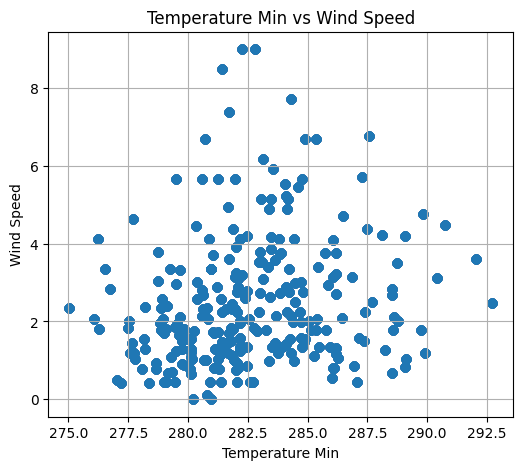

Correlation between Temperature Min and Wind Speed: 0.17313027050460075


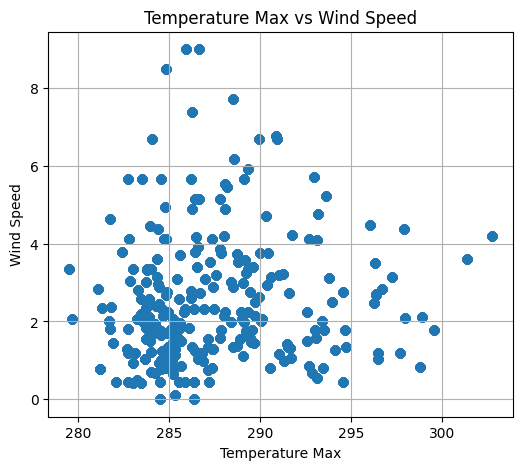

Correlation between Temperature Max and Wind Speed: 0.08728393435446871


In [57]:
# Create scatterplot for Temperature Min vs Wind Speed
plt.figure(figsize=(6, 5))
plt.scatter(merged_data_current['temperature_min'],merged_data_current['wind_speed'], alpha=0.5)
plt.title('Temperature Min vs Wind Speed')
plt.xlabel('Temperature Min')
plt.ylabel('Wind Speed')
plt.grid(True)
plt.show()

# Calculate correlation between Temperature Min and Wind Speed
corr_temp_min_wind_speed = merged_data_current['temperature_min'].corr(merged_data_current['wind_speed'])
print("Correlation between Temperature Min and Wind Speed:", corr_temp_min_wind_speed)

# Create scatterplot for Temperature Max vs Wind Speed
plt.figure(figsize=(6, 5))
plt.scatter(merged_data_current['temperature_max'], merged_data_current['wind_speed'], alpha=0.5)
plt.title('Temperature Max vs Wind Speed')
plt.xlabel('Temperature Max')
plt.ylabel('Wind Speed')
plt.grid(True)
plt.show()

# Calculate correlation between Temperature Max and Wind Speed
corr_temp_max_wind_speed = merged_data_current['temperature_max'].corr(merged_data_current['wind_speed'])
print("Correlation between Temperature Max and Wind Speed:", corr_temp_max_wind_speed)

<p><h3>Define descriptive features including day and hour granularity from current weather and five day prediction:</h3></p>

In [58]:
# Define descriptive features including day, hour and week granularity for current weather and five day prediction
# input will be station number and day and an hour
descriptive_features = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust',
    'hour_of_day',
    'day_of_week'
]
# define descriptive features for 5 day forecast, including time granularity of an hour and a day
descriptive_features_5_day = [ 
    'temp_min', 
    'temp_max', 
    'wind_speed', 
    'gust', 
    'rain_3h',
    'hour_of_day',
    'day_of_week'
]
# Define target variables for current weather and five day prediction df
weather_target_variables = [
    'bike_stand_ratio',
    'empty_stands_number',
    'total_bikes',
    'mechanical_bikes',
    'electrical_internal_battery_bikes',
    'electrical_removable_battery_bikes',
    'last_update',
]

<h3><center><strong>Merge bike/station and weather dataframes</strong></center></h3>

<p><h3>Convert data types from Kelvin to Celsius, from m/s to km/h and round floats to closest integers:</h3></p>

In [59]:
# Check the data type of temperature columns
print("Data types before conversion:")
print(merged_data_current[['feels_like', 'temperature_min', 'temperature_max']].dtypes)

Data types before conversion:
feels_like         float64
temperature_min    float64
temperature_max    float64
dtype: object


In [60]:
# Convert temperature columns from Kelvin to Celsius
merged_data_current['feels_like'] -= 273.15
merged_data_current['temperature_min'] -= 273.15
merged_data_current['temperature_max'] -= 273.15

In [61]:
# Convert wind_speed and wind_gust from m/s to km/h
merged_data_current['wind_speed'] *= 3.6
merged_data_current['wind_gust'] *= 3.6
merged_data_current.tail(3)

station_number  total_bikes  \
station_number last_update                                        
117            2024-04-12 00:00:00           117.0     7.000000   
               2024-04-12 04:00:00           117.0     6.233333   
               2024-04-12 08:00:00           117.0     5.038462   

                                    empty_stands_number status  \
station_number last_update                                       
117            2024-04-12 00:00:00            33.000000   OPEN   
               2024-04-12 04:00:00            33.766667   OPEN   
               2024-04-12 08:00:00            34.961538   OPEN   

                                    mechanical_bikes  \
station_number last_update                             
117            2024-04-12 00:00:00          7.000000   
               2024-04-12 04:00:00          6.133333   
               2024-04-12 08:00:00          3.961538   

                                    electrical_internal_battery_bikes  \
station_number last_update                                              
117            2024-04-12 00:00:00                                0.0   
               2024-04-12 04:00:00                                0.0   
               2024-04-12 08:00:00                                0.0   

                                    electrical_removable_battery_bikes  \
station_number last_update                                               
117            2024-04-12 00:00:00                            0.000000   
               2024-04-12 04:00:00                            0.100000   
               2024-04-12 08:00:00                            1.076923   

                                    feels_like  temperature_min  \
station_number last_update                                        
117            2024-04-12 00:00:00      15.700           11.095   
               2024-04-12 04:00:00      11.975            9.385   
               2024-04-12 08:00:00       9.975            7.825   

                                    temperature_max weather_description  \
station_number last_update                                                
117            2024-04-12 00:00:00            21.40         "clear sky"   
               2024-04-12 04:00:00            15.88         "clear sky"   
               2024-04-12 08:00:00            13.22         "clear sky"   

                                    wind_speed  wind_gust  
station_number last_update                                 
117            2024-04-12 00:00:00       9.936       4.86  
               2024-04-12 04:00:00       7.416       0.00  
               2024-04-12 08:00:00       0.000       0.00

In [62]:
# List of columns to round to integers
columns_to_round = ['feels_like', 'temperature_min', 'temperature_max', 'wind_speed', 'wind_gust']

# Identify non-finite values
non_finite_values = merged_data_current[columns_to_round].isna().any()

# Handle non-finite values
if non_finite_values.any():
    # Replace non-finite values with 0
    merged_data_current.fillna(0, inplace=True)  # Replace Na with 0
    merged_data_current.replace([np.inf, -np.inf], 0, inplace=True)  # Replace inf with 0

# Round each column to the nearest integer
merged_data_current[columns_to_round] = merged_data_current[columns_to_round].round().astype(int)

In [63]:
# Columns to convert to integers
columns_to_convert = ['station_number', 'empty_stands_number', 'total_bikes', 'mechanical_bikes', 
                      'electrical_internal_battery_bikes', 'electrical_removable_battery_bikes']

# Convert columns to integers
merged_data_current[columns_to_convert] = merged_data_current[columns_to_convert].astype(int)
merged_data_current.tail(3)

station_number  total_bikes  \
station_number last_update                                        
117            2024-04-12 00:00:00             117            7   
               2024-04-12 04:00:00             117            6   
               2024-04-12 08:00:00             117            5   

                                    empty_stands_number status  \
station_number last_update                                       
117            2024-04-12 00:00:00                   33   OPEN   
               2024-04-12 04:00:00                   33   OPEN   
               2024-04-12 08:00:00                   34   OPEN   

                                    mechanical_bikes  \
station_number last_update                             
117            2024-04-12 00:00:00                 7   
               2024-04-12 04:00:00                 6   
               2024-04-12 08:00:00                 3   

                                    electrical_internal_battery_bikes  \
station_number last_update                                              
117            2024-04-12 00:00:00                                  0   
               2024-04-12 04:00:00                                  0   
               2024-04-12 08:00:00                                  0   

                                    electrical_removable_battery_bikes  \
station_number last_update                                               
117            2024-04-12 00:00:00                                   0   
               2024-04-12 04:00:00                                   0   
               2024-04-12 08:00:00                                   1   

                                    feels_like  temperature_min  \
station_number last_update                                        
117            2024-04-12 00:00:00          16               11   
               2024-04-12 04:00:00          12                9   
               2024-04-12 08:00:00          10                8   

                                    temperature_max weather_description  \
station_number last_update                                                
117            2024-04-12 00:00:00               21         "clear sky"   
               2024-04-12 04:00:00               16         "clear sky"   
               2024-04-12 08:00:00               13         "clear sky"   

                                    wind_speed  wind_gust  
station_number last_update                                 
117            2024-04-12 00:00:00          10          5  
               2024-04-12 04:00:00           7          0  
               2024-04-12 08:00:00           0          0

In [64]:
# Convert temperature columns from Kelvin to Celsius
merged_data_five_day['temp_min'] -= 273.15
merged_data_five_day['temp_max'] -= 273.15

In [65]:
# List of columns to round to integers
columns_to_round = ['temp_min', 'temp_max', 'wind_speed', 'gust', 'rain_3h']

# Round each column to the nearest integer
merged_data_five_day[columns_to_round] = merged_data_five_day[columns_to_round].round().astype(int)
#merged_data_five_day.tail(3)

In [66]:
# Identify non-finite values
non_finite_values = merged_data_five_day[columns_to_convert].isna().any() | merged_data_five_day[columns_to_convert].isin([np.inf, -np.inf]).any()

# Handle non-finite values
if non_finite_values.any():
    # Replace non-finite values with 0
    merged_data_five_day.fillna(0, inplace=True)  # Replace NaN with 0
    merged_data_five_day.replace([np.inf, -np.inf], 0, inplace=True)  # Replace inf with 0

# Convert columns to integers
merged_data_five_day[columns_to_convert] = merged_data_five_day[columns_to_convert].astype(int)
merged_data_five_day.tail(3)

station_number  total_bikes  \
station_number last_update                                        
117            2024-04-16 08:00:00             117           29   
               2024-04-16 12:00:00             117           29   
               2024-04-16 16:00:00             117           17   

                                    empty_stands_number status  \
station_number last_update                                       
117            2024-04-16 08:00:00                   10   OPEN   
               2024-04-16 12:00:00                   10   OPEN   
               2024-04-16 16:00:00                   22   OPEN   

                                    mechanical_bikes  \
station_number last_update                             
117            2024-04-16 08:00:00                17   
               2024-04-16 12:00:00                17   
               2024-04-16 16:00:00                 8   

                                    electrical_internal_battery_bikes  \
station_number last_update                                              
117            2024-04-16 08:00:00                                  0   
               2024-04-16 12:00:00                                  0   
               2024-04-16 16:00:00                                  0   

                                    electrical_removable_battery_bikes  \
station_number last_update                                               
117            2024-04-16 08:00:00                                  11   
               2024-04-16 12:00:00                                  12   
               2024-04-16 16:00:00                                   9   

                                    temp_min  temp_max  wind_speed  gust  \
station_number last_update                                                 
117            2024-04-16 08:00:00         7         7           1     1   
               2024-04-16 12:00:00         8         8           1     1   
               2024-04-16 16:00:00        17        17           1     1   

                                    rain_3h  
station_number last_update                   
117            2024-04-16 08:00:00        0  
               2024-04-16 12:00:00        0  
               2024-04-16 16:00:00        0

<h3><center><strong>Training Linear Regression model</strong></center></h3>

<h3><strong>Predictive Analysis:</strong></h3>

<p><h3>Linear Regression:</h3></p>

In [67]:
# Check if 'station_number' column exists in the DataFrame
if 'station_number' in merged_data_current.columns:
    # Drop 'station_number' column if it exists
    merged_data_current.drop('station_number', axis=1, inplace=True)

# Reset the index temporarily to extract features
merged_current_reset = merged_data_current.reset_index()

# Set last_update back as the index
merged_current_station_df = merged_current_reset.set_index('last_update')

# Define descriptive features including weather prediction
descriptive_features_current_prediction = [
    'temperature_min', 
    'temperature_max', 
    'wind_speed',
    'wind_gust',
]

# Define target variables
target_variables_current_prediction = [
    'electrical_internal_battery_bikes',
    'mechanical_bikes',
    'electrical_removable_battery_bikes',
    'empty_stands_number',
    'total_bikes',
]

# Extract descriptive features (X) and target variables (y)
X = merged_current_station_df[descriptive_features_current_prediction]
y = merged_current_station_df[target_variables_current_prediction]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train separate linear regression models for each target variable
models = {}
for target in target_variables_current_prediction:
    lr = LinearRegression()
    lr.fit(X_train, y_train[target])
    models[target] = lr

    # Make predictions on the training set
    y_train_pred = lr.predict(X_train)

    # Make predictions on the testing set
    y_test_pred = lr.predict(X_test)

    # Evaluate the model
    r_squared_train = r2_score(y_train[target], y_train_pred)
    mse_train = mean_squared_error(y_train[target], y_train_pred)
    r_squared_test = r2_score(y_test[target], y_test_pred)
    mse_test = mean_squared_error(y_test[target], y_test_pred)

    print(f"\nMetrics for {target}:")
    print("Training Set:")
    print("R-squared:", r_squared_train)
    print("Mean Squared Error:", mse_train)
    print("Testing Set:")
    print("R-squared:", r_squared_test)
    print("Mean Squared Error:", mse_test)



Metrics for electrical_internal_battery_bikes:
Training Set:
R-squared: 1.0
Mean Squared Error: 0.0
Testing Set:
R-squared: 1.0
Mean Squared Error: 0.0

Metrics for mechanical_bikes:
Training Set:
R-squared: 0.0035511240240377884
Mean Squared Error: 41.63901757738742
Testing Set:
R-squared: -0.0013823938539894165
Mean Squared Error: 39.04258410375369

Metrics for electrical_removable_battery_bikes:
Training Set:
R-squared: 0.0028559104423181436
Mean Squared Error: 17.149535750388214
Testing Set:
R-squared: -0.002515809649790146
Mean Squared Error: 15.588625580556888

Metrics for empty_stands_number:
Training Set:
R-squared: 0.013138873903949744
Mean Squared Error: 117.34095993641199
Testing Set:
R-squared: -0.21803452248525845
Mean Squared Error: 163.16229525526697

Metrics for total_bikes:
Training Set:
R-squared: 0.0041747905326873225
Mean Squared Error: 93.46401090277365
Testing Set:
R-squared: -0.002503911496955391
Mean Squared Error: 82.22423090393684


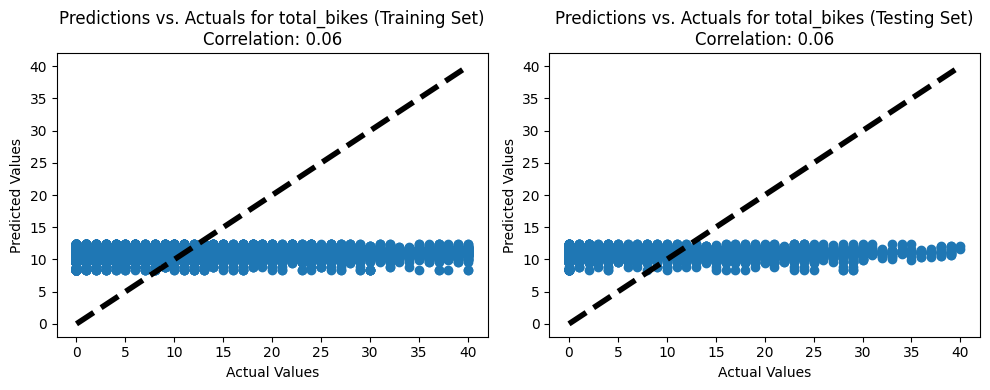

In [68]:
# Calculate correlation between actual and predicted values
corr_train = np.corrcoef(y_train[target], y_train_pred)[0, 1]
corr_test = np.corrcoef(y_test[target], y_test_pred)[0, 1]

# Plotting predictions vs. actuals for training set
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_train[target], y_train_pred)
plt.plot([min(y_train[target]), max(y_train[target])], [min(y_train[target]), max(y_train[target])], 'k--', lw=4)
plt.title(f'Predictions vs. Actuals for {target} (Training Set)\nCorrelation: {corr_train:.2f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting predictions vs. actuals for testing set
plt.subplot(1, 2, 2)
plt.scatter(y_test[target], y_test_pred)
plt.plot([min(y_test[target]), max(y_test[target])], [min(y_test[target]), max(y_test[target])], 'k--', lw=4)
plt.title(f'Predictions vs. Actuals for {target} (Testing Set)\nCorrelation: {corr_test:.2f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [69]:
# Check if 'station_number' column exists in the DataFrame
if 'station_number' in merged_data_five_day.columns:
    # Drop 'station_number' column if it exists
    merged_data_five_day.drop('station_number', axis=1, inplace=True)

# Reset the index temporarily to extract features
merged_five_day_reset = merged_data_five_day.reset_index()

# Define descriptive features including time weather prediction
descriptive_features_five_day_prediction_resampled = [
    'temp_min', 
    'temp_max', 
    'wind_speed', 
    'gust',
    'rain_3h'
]

# Define target variables
target_variables_five_day_prediction_resampled = [
    'electrical_internal_battery_bikes',
    'mechanical_bikes',
    'electrical_removable_battery_bikes',
    'empty_stands_number',
    'total_bikes',
]

# Group the merged station weather data by station_number
grouped_data = merged_data_five_day.groupby('station_number')

# Iterate over each group (station)
for station_number, group_data in grouped_data:
    print(f"\nTraining model for station number: {station_number}")
    
    # Extract descriptive features (X) and target variables (y)
    X = group_data[descriptive_features_five_day_prediction_resampled]
    y = group_data[target_variables_five_day_prediction_resampled]
    
    # Train a linear regression model
    linreg = LinearRegression()
    linreg.fit(X, y)
    
    # Make predictions
    y_pred = linreg.predict(X)
    
    # Calculate feels_like based on temperature_min and temperature_max
    feels_like_values = (y_pred[:, 0] + y_pred[:, 1]) / 2

    # Ensure that feels_like_values are in the correct data type (float64)
    feels_like_values = feels_like_values.astype(float)

    # Round feels_like_values to the nearest integer
    group_data.loc[:, 'feels_like'] = np.round(feels_like_values).astype(int)
    
    # Calculate R-squared
    r_squared = r2_score(y, y_pred)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y, y_pred)
    
    print("\nModel performance:")
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)
    
    # Save the trained model to a pickle file
    # model_filename = f"{station_number}_model_five_day_prediction_for_each_station.pickle"
    #with open(model_filename, 'wb') as f:
    #     pickle.dump(linreg, f)
    
    #print(f"Linear regression model for station number {station_number} saved as {model_filename}")


Training model for station number: 1

Model performance:
R-squared: 0.27765496893989444
Mean Squared Error: 43.3634135014131

Training model for station number: 2

Model performance:
R-squared: 0.2858015581281126
Mean Squared Error: 9.569280792705474

Training model for station number: 3

Model performance:
R-squared: 0.25101480065710435
Mean Squared Error: 17.371119341360448

Training model for station number: 4

Model performance:
R-squared: 0.29123287173012563
Mean Squared Error: 13.149971442084677

Training model for station number: 5

Model performance:
R-squared: 0.32616316558467934
Mean Squared Error: 73.607775893477

Training model for station number: 6

Model performance:
R-squared: 0.23247274294133796
Mean Squared Error: 16.477489729970937

Training model for station number: 7

Model performance:
R-squared: 0.22721973519702982
Mean Squared Error: 26.578843847022426

Training model for station number: 8

Model performance:
R-squared: 0.2611927823376058
Mean Squared Error: 31.

In [72]:
#%%capture
# Iterate over each station number from 1 to 118, to create serialized output for each station pickle
for station_number in range(1, 118):
    # Construct the input filename
    input_filename = f"{station_number}_model_five_day_prediction_for_each_station.pickle"
    
    # Check if the input file exists
    if os.path.exists(input_filename):
        # Load the input data for the current station from the pickle file
        with open(input_filename, 'rb') as f:
            station_data = pickle.load(f)

        # Generate the output filename
        output_filename = f"{station_number}_output_data.pickle"

        # Save the station data to the output file
        with open(output_filename, 'wb') as f:
            pickle.dump(station_data, f)

        print(f"Output data for station number {station_number} saved as {output_filename}")
    else:
        print(f"Input file for station number {station_number} not found.")

Output data for station number 1 saved as 1_output_data.pickle
Output data for station number 2 saved as 2_output_data.pickle
Output data for station number 3 saved as 3_output_data.pickle
Output data for station number 4 saved as 4_output_data.pickle
Output data for station number 5 saved as 5_output_data.pickle
Output data for station number 6 saved as 6_output_data.pickle
Output data for station number 7 saved as 7_output_data.pickle
Output data for station number 8 saved as 8_output_data.pickle
Output data for station number 9 saved as 9_output_data.pickle
Input file for station number 10 not found.
Output data for station number 11 saved as 11_output_data.pickle
Output data for station number 12 saved as 12_output_data.pickle
Output data for station number 13 saved as 13_output_data.pickle
Output data for station number 14 saved as 14_output_data.pickle
Output data for station number 15 saved as 15_output_data.pickle
Output data for station number 16 saved as 16_output_data.pickle

In [73]:
# Check if 'station_number' column exists in the DataFrame
if 'station_number' in merged_data_current.columns:
    # Drop 'station_number' column if it exists
    merged_data_current.drop('station_number', axis=1, inplace=True)

# Reset the index temporarily to extract features
merged_current_reset = merged_data_current.reset_index()

# Define descriptive features including time weather prediction
descriptive_features_current_prediction_resampled = [
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust'
]

# Define target variables
target_variables_current_prediction_resampled = [
    'electrical_internal_battery_bikes',
    'mechanical_bikes',
    'electrical_removable_battery_bikes',
    'empty_stands_number',
    'total_bikes',
]

# Group the merged station weather data by station_number
grouped_data = merged_data_current.groupby('station_number')

# Iterate over each group (station)
for station_number, group_data in grouped_data:
    print(f"\nTraining model for station number: {station_number}")
    
    # Extract descriptive features (X) and target variables (y)
    X = group_data[descriptive_features_current_prediction_resampled]
    y = group_data[target_variables_current_prediction_resampled]
    
    # Train a linear regression model
    linreg = LinearRegression()
    linreg.fit(X, y)
    
    # Make predictions
    y_pred = linreg.predict(X)
    
    # Calculate feels_like based on temperature_min and temperature_max
    feels_like_values = (y_pred[:, 0] + y_pred[:, 1]) / 2

    # Ensure that feels_like_values are in the correct data type (float64)
    feels_like_values = feels_like_values.astype(float)

    # Round feels_like_values to the nearest integer
    group_data.loc[:, 'feels_like'] = np.round(feels_like_values).astype(int)
    
    # Calculate R-squared
    r_squared = r2_score(y, y_pred)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y, y_pred)
    
    print("\nModel performance:")
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)
    
    # Save the trained model to a pickle file
    # model_filename = f"{station_number}_model_current_for_each_station.pickle"
    #with open(model_filename, 'wb') as f:
    #     pickle.dump(linreg, f)
    
    #print(f"Linear regression model for station number {station_number} saved as {model_filename}")


Training model for station number: 1

Model performance:
R-squared: 0.23786252010767323
Mean Squared Error: 46.35185428157774

Training model for station number: 2

Model performance:
R-squared: 0.2627064779612443
Mean Squared Error: 10.698066772992824

Training model for station number: 3

Model performance:
R-squared: 0.22912413678836807
Mean Squared Error: 17.605117914409817

Training model for station number: 4

Model performance:
R-squared: 0.26362230013085514
Mean Squared Error: 13.366773832291216

Training model for station number: 5

Model performance:
R-squared: 0.31589378487441533
Mean Squared Error: 76.87828437539777

Training model for station number: 6

Model performance:
R-squared: 0.20889552704994938
Mean Squared Error: 17.15515148411753

Training model for station number: 7

Model performance:
R-squared: 0.21944646576158094
Mean Squared Error: 27.581422910450094

Training model for station number: 8

Model performance:
R-squared: 0.2511450470641684
Mean Squared Error: 

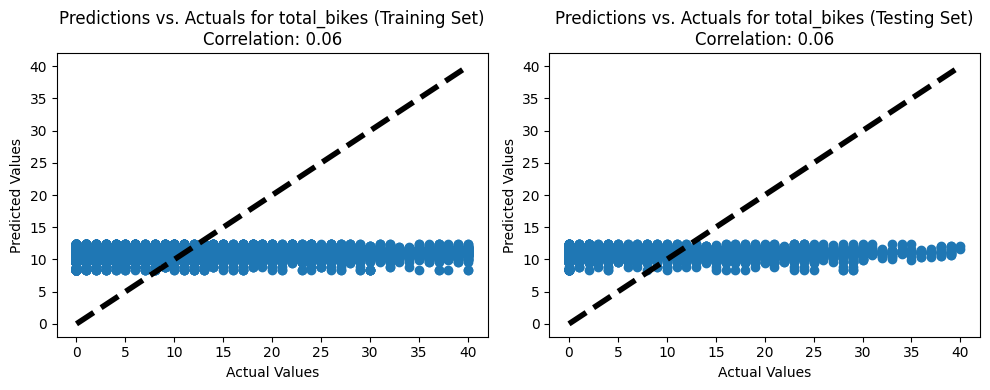

In [74]:
# Calculate correlation between actual and predicted values
corr_train = np.corrcoef(y_train[target], y_train_pred)[0, 1]
corr_test = np.corrcoef(y_test[target], y_test_pred)[0, 1]

# Plotting predictions vs. actuals for training set
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_train[target], y_train_pred)
plt.plot([min(y_train[target]), max(y_train[target])], [min(y_train[target]), max(y_train[target])], 'k--', lw=4)
plt.title(f'Predictions vs. Actuals for {target} (Training Set)\nCorrelation: {corr_train:.2f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting predictions vs. actuals for testing set
plt.subplot(1, 2, 2)
plt.scatter(y_test[target], y_test_pred)
plt.plot([min(y_test[target]), max(y_test[target])], [min(y_test[target]), max(y_test[target])], 'k--', lw=4)
plt.title(f'Predictions vs. Actuals for {target} (Testing Set)\nCorrelation: {corr_test:.2f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [75]:
# checking all the df in jupyter notebook
%who DataFrame

X	 X_test	 X_train	 df_current_weather	 df_current_weather_head	 df_current_weather_resampled	 df_five_day_prediction	 df_five_day_prediction_head	 df_five_day_prediction_resampled	 
df_station_status	 df_station_status_head	 df_station_status_regrouped	 group_data	 merged_current_reset	 merged_current_station_df	 merged_data_current	 merged_data_five_day	 merged_five_day_reset	 
outliers	 station_status_resampled	 y	 y_test	 y_train	 
